# 02: Baseline Models

This notebook trains and evaluates baseline machine learning models:
- Logistic Regression (with proper scaling)
- Random Forest
- Model evaluation on train, validation, and test sets
- Feature importance analysis
- Save trained models and predictions for fairness analysis

**Note:** Fairness analysis is performed separately in notebook 03_fairness_analysis.ipynb

In [1]:
# Check if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# Install packages (for Google Colab)
if IN_COLAB:
    !pip install scikit-learn matplotlib seaborn -q

# Imports
import pandas as pd
import numpy as np
import pickle
import json
import time
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix, roc_curve)
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting setup
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Set random seed for reproducibility
np.random.seed(42)

print("=" * 60)
print("BASELINE MODELS - INSURANCE CLAIM PREDICTION")
print("=" * 60)
print("Setup complete!")


BASELINE MODELS - INSURANCE CLAIM PREDICTION
Setup complete!


## 1. Load Preprocessed Data

Load the processed data from the preprocessing notebook. Works both locally and on Google Colab.


In [2]:
# Determine data directory (works for both local and Colab)
if IN_COLAB:
    # Mount Google Drive for Colab
    from google.colab import drive
    drive.mount('/content/drive')
    
    # Try common Colab paths
    possible_paths = [
        Path('/content/drive/MyDrive/6.3950_project/processed_data'),
        Path('/content/drive/Shareddrives/Insurance Fairness/processed_data'),
        Path('/content/drive/MyDrive/insurance-fairness/results'),
        Path('../results')
    ]
else:
    # Local paths
    possible_paths = [
        Path('../results'),
        Path('./results')
    ]

data_dir = None
for path in possible_paths:
    if path.exists() and (path / 'X_train.pkl').exists():
        data_dir = path
        break

if data_dir is None:
    error_msg = (
        "Could not find preprocessed data. Please run notebook 01_preprocessing.ipynb first.\n"
        f"Tried paths: {', '.join([str(p) for p in possible_paths])}\n"
        "\nTroubleshooting tips:\n"
        "  - Ensure you've run 01_preprocessing.ipynb completely\n"
        "  - Check that the results/ directory exists\n"
        "  - For Colab: Verify Google Drive is mounted correctly"
    )
    raise FileNotFoundError(error_msg)

print(f"Loading data from: {data_dir}")
print("Loading preprocessed data...")

# Load all data splits
with open(data_dir / 'X_train.pkl', 'rb') as f: X_train = pickle.load(f)
with open(data_dir / 'X_val.pkl', 'rb') as f: X_val = pickle.load(f)
with open(data_dir / 'X_test.pkl', 'rb') as f: X_test = pickle.load(f)
with open(data_dir / 'y_train.pkl', 'rb') as f: y_train = pickle.load(f)
with open(data_dir / 'y_val.pkl', 'rb') as f: y_val = pickle.load(f)
with open(data_dir / 'y_test.pkl', 'rb') as f: y_test = pickle.load(f)
with open(data_dir / 'protected_train.pkl', 'rb') as f: protected_train = pickle.load(f)
with open(data_dir / 'protected_val.pkl', 'rb') as f: protected_val = pickle.load(f)
with open(data_dir / 'protected_test.pkl', 'rb') as f: protected_test = pickle.load(f)
with open(data_dir / 'feature_names.pkl', 'rb') as f: feature_names = pickle.load(f)

# Validate data shapes
assert X_train.shape[1] == X_val.shape[1] == X_test.shape[1], "Feature count mismatch"
assert len(y_train) == len(X_train), "Label/feature count mismatch"
assert len(protected_train) == len(X_train), "Protected attributes count mismatch"

# Load scaler (data is already scaled, but we keep it for consistency)
try:
    with open(data_dir / 'scaler.pkl', 'rb') as f: scaler = pickle.load(f)
    print("Scaler loaded (data is already scaled)")
except FileNotFoundError:
    print("Scaler not found, but data should already be scaled")
    scaler = None

print("\nDATA LOADED!")
print(f"   Training: {X_train.shape[0]:,} samples × {X_train.shape[1]} features")
print(f"   Validation: {X_val.shape[0]:,} samples")
print(f"   Test: {X_test.shape[0]:,} samples")
print(f"   Class balance (train): {(y_train == 0).sum():,} No, {(y_train == 1).sum():,} Yes")

# Additional validation checks
print("\nData Validation:")
# Convert to numpy array if DataFrame to get scalar min/max values
X_train_array = np.array(X_train) if hasattr(X_train, 'values') else X_train
print(f"   Feature value ranges (train): min={X_train_array.min():.2f}, max={X_train_array.max():.2f}")
print(f"   Missing values: {np.isnan(X_train_array).sum()} in features, {np.isnan(y_train).sum()} in labels")
print(f"   Class distribution (train): {(y_train == 1).mean():.2%} positive class")
print(f"   Class distribution (val): {(y_val == 1).mean():.2%} positive class")
print(f"   Class distribution (test): {(y_test == 1).mean():.2%} positive class")

# Check for data quality issues
if np.isnan(X_train_array).any() or np.isnan(y_train).any():
    print("   WARNING: Missing values detected!")
if (y_train == 1).mean() < 0.01 or (y_train == 1).mean() > 0.99:
    print("   WARNING: Extreme class imbalance detected!")


Loading data from: ..\results
Loading preprocessed data...
Scaler loaded (data is already scaled)

DATA LOADED!
   Training: 6,396 samples × 54 features
   Validation: 1,367 samples
   Test: 1,371 samples
   Class balance (train): 5,480 No, 916 Yes

Data Validation:
   Feature value ranges (train): min=-1.72, max=11.62
   Missing values: 0 in features, 0 in labels
   Class distribution (train): 14.32% positive class
   Class distribution (val): 14.34% positive class
   Class distribution (test): 14.30% positive class


## 2. Model 1: Logistic Regression

Logistic Regression is interpretable and widely used in insurance. Note: The data is already scaled from preprocessing.

**Prediction Threshold:** Binary predictions use the default threshold of 0.5 (i.e., predict class 1 if probability ≥ 0.5).



LOGISTIC REGRESSION
Training Logistic Regression...
Training completed in 0.02 seconds
Generating predictions...

Train Set Performance:
   ACCURACY    : 0.7133
   PRECISION   : 0.3030
   RECALL      : 0.7707
   F1          : 0.4350
   ROC_AUC     : 0.8182

Validation Set Performance:
   ACCURACY    : 0.7176
   PRECISION   : 0.3069
   RECALL      : 0.7704
   F1          : 0.4390
   ROC_AUC     : 0.8191

Test Set Performance:
   ACCURACY    : 0.7119
   PRECISION   : 0.2990
   RECALL      : 0.7551
   F1          : 0.4284
   ROC_AUC     : 0.8044


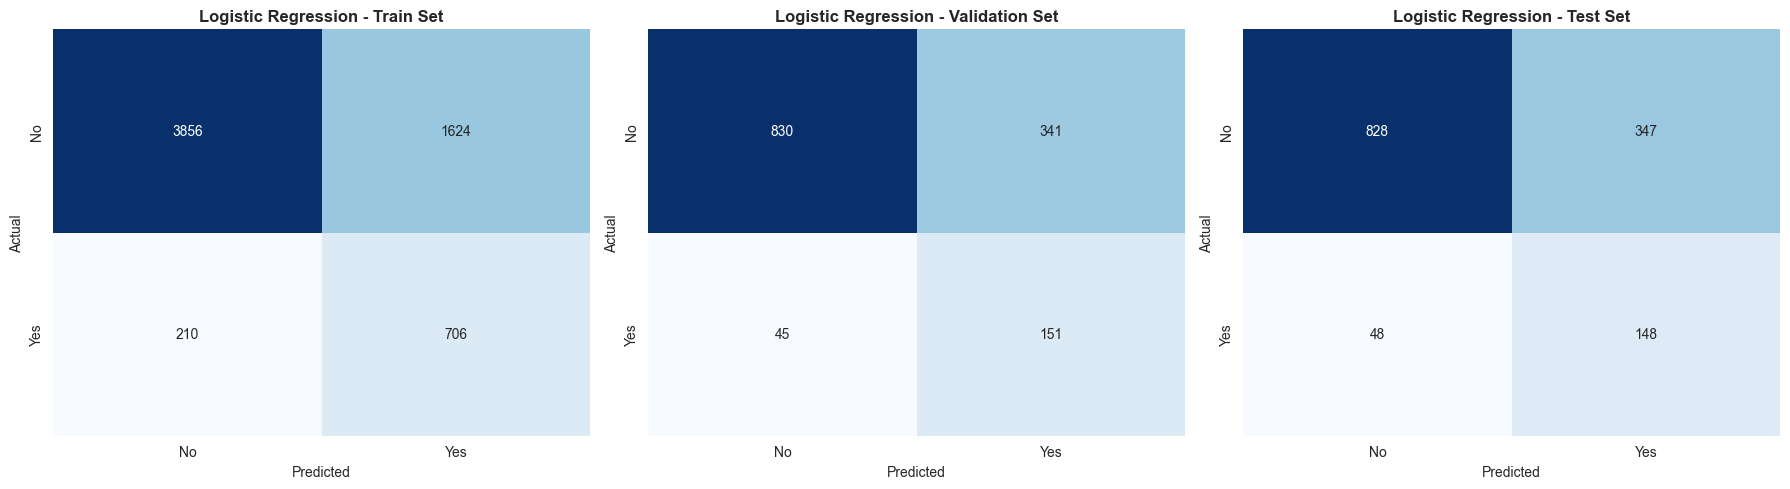

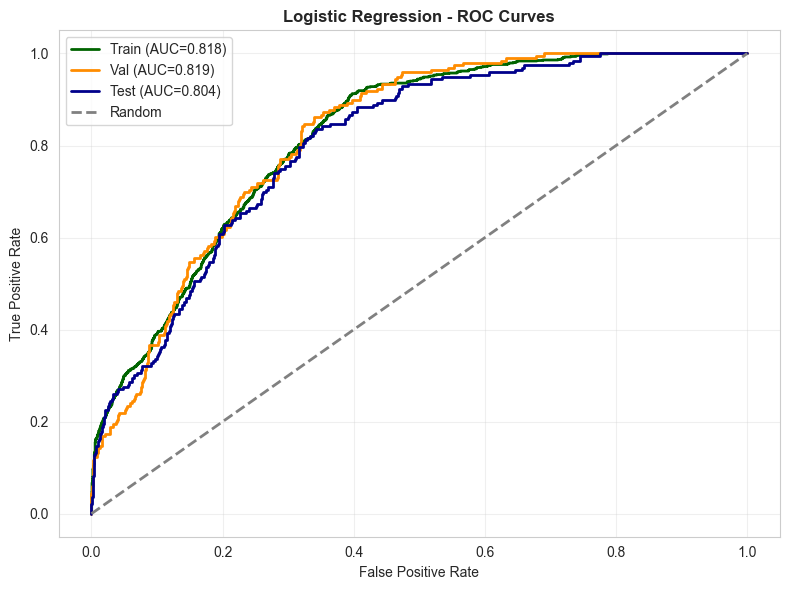


Logistic Regression complete!


In [5]:
# ============================================================
# MODEL 1: LOGISTIC REGRESSION
# ============================================================

print("\n" + "=" * 60)
print("LOGISTIC REGRESSION")
print("=" * 60)

# Train model (data is already scaled)
logistic_model = LogisticRegression(
    class_weight='balanced', 
    max_iter=1000, 
    random_state=42,
    solver='lbfgs'  # Good default solver
)
print("Training Logistic Regression...")
start_time = time.time()
logistic_model.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Make predictions on all sets
# Note: predict() uses default threshold of 0.5 for binary classification
print("Generating predictions...")
y_train_pred_lr = logistic_model.predict(X_train)
y_train_proba_lr = logistic_model.predict_proba(X_train)[:, 1]
y_val_pred_lr = logistic_model.predict(X_val)
y_val_proba_lr = logistic_model.predict_proba(X_val)[:, 1]
y_test_pred_lr = logistic_model.predict(X_test)
y_test_proba_lr = logistic_model.predict_proba(X_test)[:, 1]

# Calculate metrics for validation and test sets
def calculate_metrics(y_true, y_pred, y_proba, set_name):
    """
    Calculate comprehensive classification metrics.
       
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred : array-like
        Predicted labels
    y_proba : array-like
        Predicted probabilities for positive class
    set_name : str
        Name of the dataset (for tracking)
           
    Returns:
    --------
    dict : Dictionary containing accuracy, precision, recall, f1, roc_auc
    """
    return {
        'set': set_name,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_true, y_proba) if len(np.unique(y_true)) > 1 else 0.0
    }

lr_val_metrics = calculate_metrics(y_val, y_val_pred_lr, y_val_proba_lr, 'Validation')
lr_test_metrics = calculate_metrics(y_test, y_test_pred_lr, y_test_proba_lr, 'Test')
lr_train_metrics = calculate_metrics(y_train, y_train_pred_lr, y_train_proba_lr, 'Train')

print("\nTrain Set Performance:")
for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
    print(f"   {metric.upper():12s}: {lr_train_metrics[metric]:.4f}")

print("\nValidation Set Performance:")
for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
    print(f"   {metric.upper():12s}: {lr_val_metrics[metric]:.4f}")

print("\nTest Set Performance:")
for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
    print(f"   {metric.upper():12s}: {lr_test_metrics[metric]:.4f}")

# Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (y_true, y_pred, title) in enumerate([
    (y_train, y_train_pred_lr, 'Train Set'),
    (y_val, y_val_pred_lr, 'Validation Set'),
    (y_test, y_test_pred_lr, 'Test Set')
]):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], cbar=False)
    axes[idx].set_title(f'Logistic Regression - {title}', fontweight='bold')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xticklabels(['No', 'Yes'])
    axes[idx].set_yticklabels(['No', 'Yes'])

plt.tight_layout()
plt.show()

# ROC Curves
fig, ax = plt.subplots(figsize=(8, 6))

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba_lr)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba_lr)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba_lr)

ax.plot(fpr_train, tpr_train, 'darkgreen', lw=2, 
        label=f'Train (AUC={lr_train_metrics["roc_auc"]:.3f})')
ax.plot(fpr_val, tpr_val, 'darkorange', lw=2, 
        label=f'Val (AUC={lr_val_metrics["roc_auc"]:.3f})')
ax.plot(fpr_test, tpr_test, 'darkblue', lw=2, 
        label=f'Test (AUC={lr_test_metrics["roc_auc"]:.3f})')
ax.plot([0, 1], [0, 1], 'gray', lw=2, linestyle='--', label='Random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Logistic Regression - ROC Curves', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nLogistic Regression complete!")


### 2.1 Logistic Regression Feature Importance Analysis

Understanding which features drive the Logistic Regression predictions.


LOGISTIC REGRESSION - FEATURE COEFFICIENTS

Top 15 Most Important Features (by absolute coefficient):
                    feature  coefficient
    Renew Offer Type_Offer4    -2.100397
     Location Code_Suburban     0.788867
    Renew Offer Type_Offer3    -0.757461
   EmploymentStatus_Retired     0.448743
         Total Claim Amount    -0.448524
    Renew Offer Type_Offer2     0.363259
       Sales Channel_Branch    -0.317423
      Marital Status_Single    -0.308631
     Marital Status_Married    -0.290668
         Vehicle Size_Small    -0.271201
       Monthly Premium Auto     0.240066
  Sales Channel_Call Center    -0.235597
          Sales Channel_Web    -0.196108
           Education_Master     0.182921
EmploymentStatus_Unemployed    -0.178423


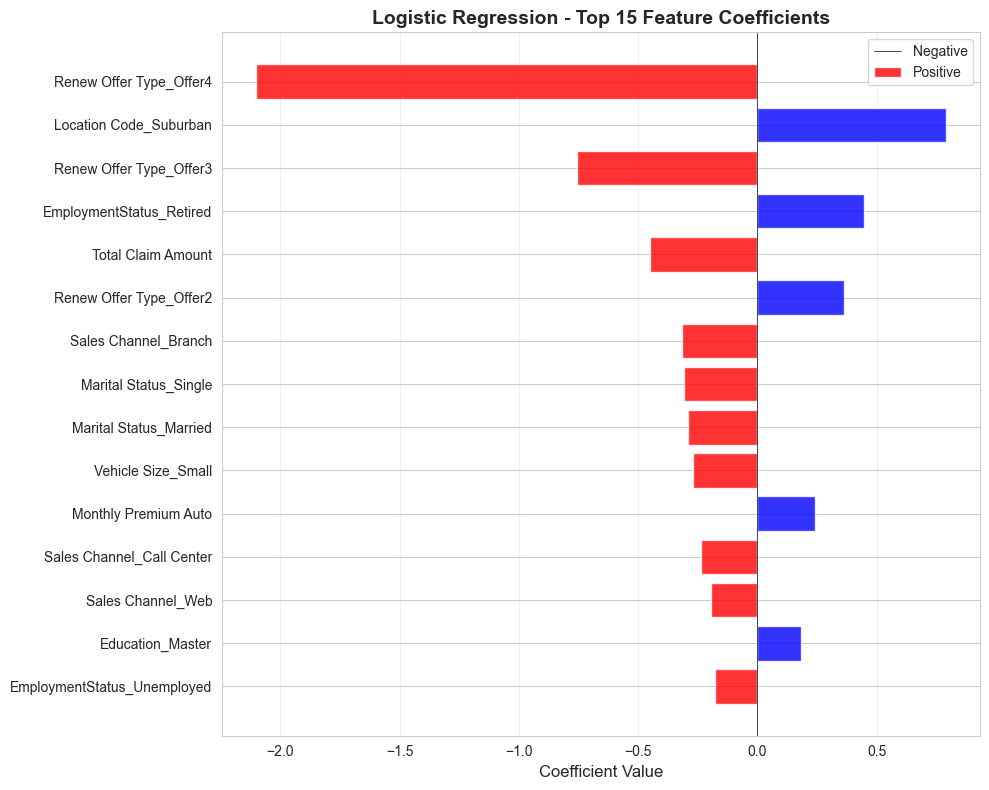


Logistic Regression coefficient analysis complete!


In [6]:
# ============================================================
# LOGISTIC REGRESSION FEATURE IMPORTANCE (COEFFICIENTS)
# ============================================================

print("\n" + "=" * 60)
print("LOGISTIC REGRESSION - FEATURE COEFFICIENTS")
print("=" * 60)

# Get feature coefficients (feature importance for linear models)
if len(feature_names) != len(logistic_model.coef_[0]):
    raise ValueError(f"Feature names count ({len(feature_names)}) doesn't match model coefficients ({len(logistic_model.coef_[0])})")

lr_coefficients = pd.DataFrame({
    'feature': feature_names,
    'coefficient': logistic_model.coef_[0],
    'abs_coefficient': np.abs(logistic_model.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

print("\nTop 15 Most Important Features (by absolute coefficient):")
print(lr_coefficients.head(15)[['feature', 'coefficient']].to_string(index=False))

# Visualize top coefficients
top_n = 15
fig, ax = plt.subplots(figsize=(10, 8))
top_coefs = lr_coefficients.head(top_n)

colors = ['red' if c < 0 else 'blue' for c in top_coefs['coefficient']]
ax.barh(range(len(top_coefs)), top_coefs['coefficient'], color=colors, alpha=0.8)
ax.set_yticks(range(len(top_coefs)))
ax.set_yticklabels(top_coefs['feature'])
ax.invert_yaxis()
ax.set_xlabel('Coefficient Value', fontsize=12)
ax.set_title(f'Logistic Regression - Top {top_n} Feature Coefficients', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.grid(axis='x', alpha=0.3)
ax.legend(['Negative', 'Positive'], loc='best')

plt.tight_layout()
plt.show()

print("\nLogistic Regression coefficient analysis complete!")


## 3. Model 2: Random Forest

Random Forest can capture non-linear relationships and feature interactions. Trees don't require scaling.

**Prediction Threshold:** Binary predictions use the default threshold of 0.5 (i.e., predict class 1 if probability ≥ 0.5).



RANDOM FOREST
Training Random Forest (this may take a minute)...
Training completed in 0.24 seconds
Generating predictions...

Train Set Performance:
   ACCURACY    : 0.9443
   PRECISION   : 0.7201
   RECALL      : 1.0000
   F1          : 0.8373
   ROC_AUC     : 0.9982

Validation Set Performance:
   ACCURACY    : 0.9298
   PRECISION   : 0.6724
   RECALL      : 0.9949
   F1          : 0.8025
   ROC_AUC     : 0.9907

Test Set Performance:
   ACCURACY    : 0.9161
   PRECISION   : 0.6311
   RECALL      : 0.9949
   F1          : 0.7723
   ROC_AUC     : 0.9907


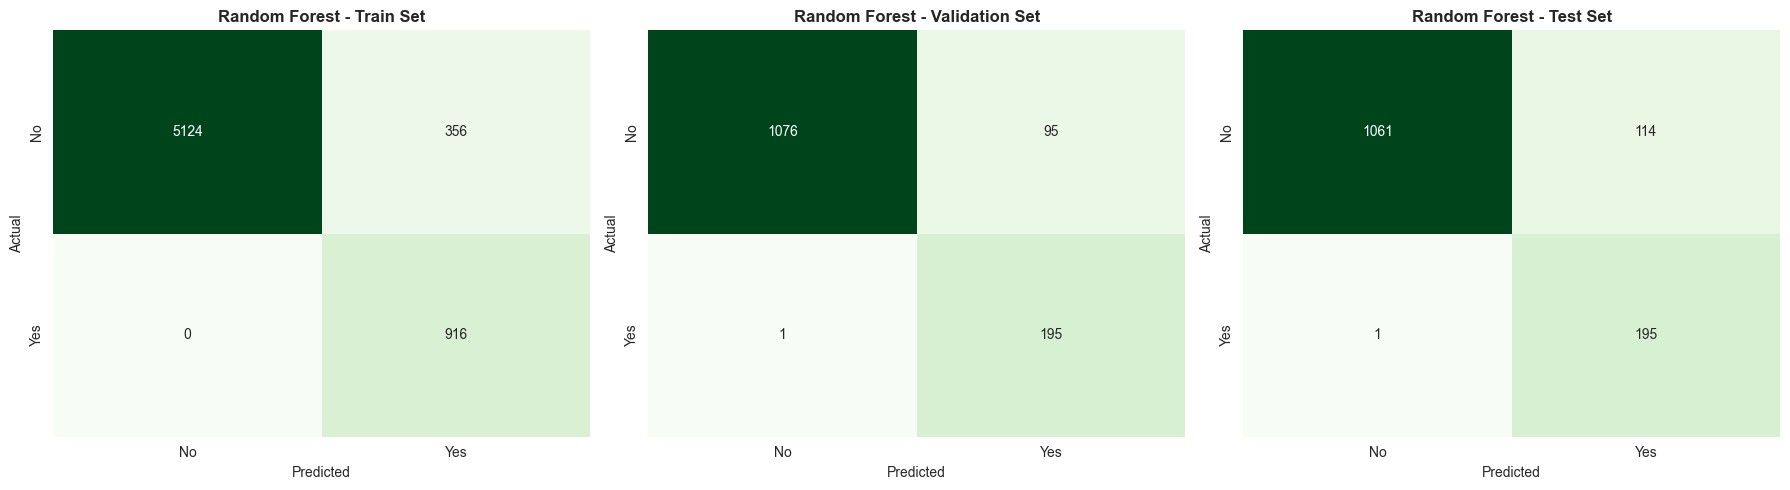

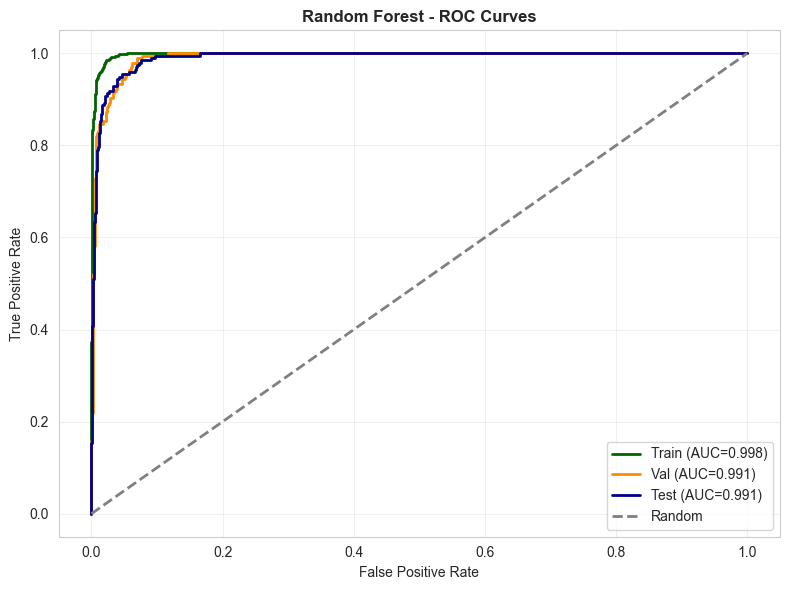


Random Forest complete!


In [7]:
# ============================================================
# MODEL 2: RANDOM FOREST
# ============================================================

print("\n" + "=" * 60)
print("RANDOM FOREST")
print("=" * 60)

# Train model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
print("Training Random Forest (this may take a minute)...")
start_time = time.time()
rf_model.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Make predictions on all sets
# Note: predict() uses default threshold of 0.5 for binary classification
print("Generating predictions...")
y_train_pred_rf = rf_model.predict(X_train)
y_train_proba_rf = rf_model.predict_proba(X_train)[:, 1]
y_val_pred_rf = rf_model.predict(X_val)
y_val_proba_rf = rf_model.predict_proba(X_val)[:, 1]
y_test_pred_rf = rf_model.predict(X_test)
y_test_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Calculate metrics
rf_val_metrics = calculate_metrics(y_val, y_val_pred_rf, y_val_proba_rf, 'Validation')
rf_test_metrics = calculate_metrics(y_test, y_test_pred_rf, y_test_proba_rf, 'Test')
rf_train_metrics = calculate_metrics(y_train, y_train_pred_rf, y_train_proba_rf, 'Train')

print("\nTrain Set Performance:")
for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
    print(f"   {metric.upper():12s}: {rf_train_metrics[metric]:.4f}")

print("\nValidation Set Performance:")
for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
    print(f"   {metric.upper():12s}: {rf_val_metrics[metric]:.4f}")

print("\nTest Set Performance:")
for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
    print(f"   {metric.upper():12s}: {rf_test_metrics[metric]:.4f}")

# Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (y_true, y_pred, title) in enumerate([
    (y_train, y_train_pred_rf, 'Train Set'),
    (y_val, y_val_pred_rf, 'Validation Set'),
    (y_test, y_test_pred_rf, 'Test Set')
]):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=axes[idx], cbar=False)
    axes[idx].set_title(f'Random Forest - {title}', fontweight='bold')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xticklabels(['No', 'Yes'])
    axes[idx].set_yticklabels(['No', 'Yes'])

plt.tight_layout()
plt.show()

# ROC Curves
fig, ax = plt.subplots(figsize=(8, 6))

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba_rf)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba_rf)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba_rf)

ax.plot(fpr_train, tpr_train, 'darkgreen', lw=2, 
        label=f'Train (AUC={rf_train_metrics["roc_auc"]:.3f})')
ax.plot(fpr_val, tpr_val, 'darkorange', lw=2, 
        label=f'Val (AUC={rf_val_metrics["roc_auc"]:.3f})')
ax.plot(fpr_test, tpr_test, 'darkblue', lw=2, 
        label=f'Test (AUC={rf_test_metrics["roc_auc"]:.3f})')
ax.plot([0, 1], [0, 1], 'gray', lw=2, linestyle='--', label='Random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Random Forest - ROC Curves', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nRandom Forest complete!")


### 3.1 Random Forest Feature Importance Analysis

Understanding which features drive the Random Forest predictions.



FEATURE IMPORTANCE ANALYSIS

Top 15 Most Important Features:
                      feature  importance
           Total Claim Amount    0.077680
      Renew Offer Type_Offer4    0.074548
      Renew Offer Type_Offer3    0.073760
                       Income    0.064968
      Customer Lifetime Value    0.064942
Months Since Policy Inception    0.057279
     EmploymentStatus_Retired    0.055483
      Renew Offer Type_Offer2    0.053488
         Monthly Premium Auto    0.053030
      Months Since Last Claim    0.047943
          Effective_DayOfWeek    0.031537
       Location Code_Suburban    0.030496
           Number of Policies    0.027694
              Effective_Month    0.026677
        Marital Status_Single    0.023314


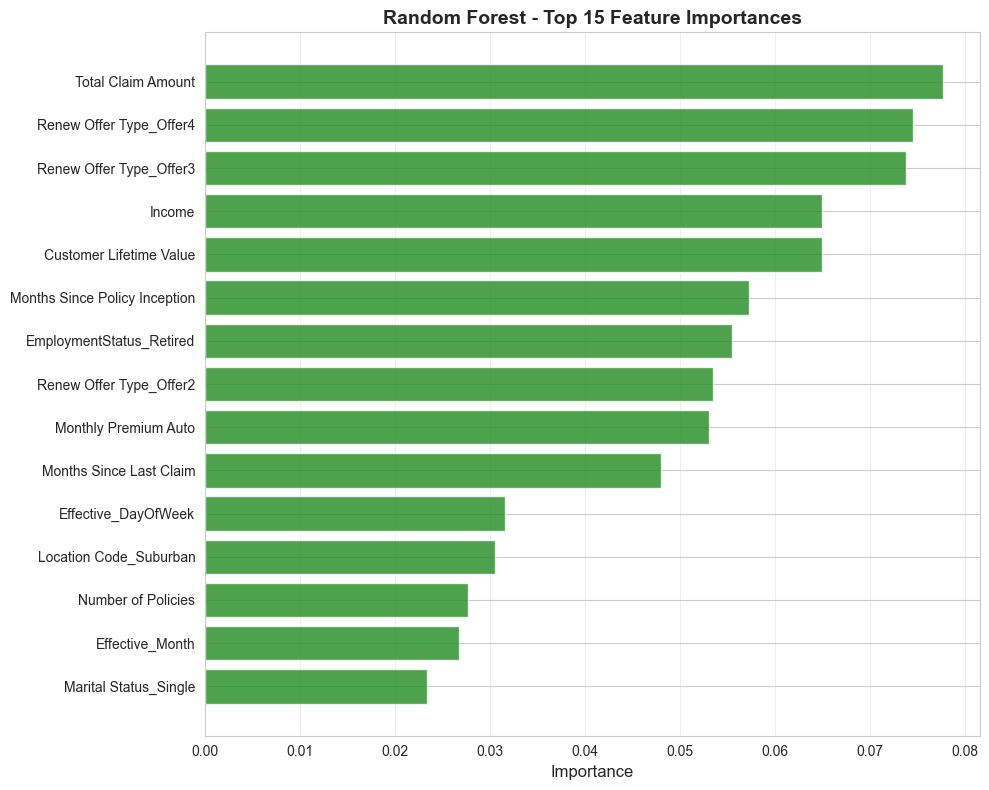


Feature importance analysis complete!


In [8]:
# ============================================================
# FEATURE IMPORTANCE - RANDOM FOREST
# ============================================================

print("\n" + "=" * 60)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

# Get feature importances
if len(feature_names) != len(rf_model.feature_importances_):
    raise ValueError(f"Feature names count ({len(feature_names)}) doesn't match model features ({len(rf_model.feature_importances_)})")

feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 Most Important Features:")
print(feature_importance.head(15).to_string(index=False))

# Visualize top features
top_n = 15
fig, ax = plt.subplots(figsize=(10, 8))
top_features = feature_importance.head(top_n)

ax.barh(range(len(top_features)), top_features['importance'], color='forestgreen', alpha=0.8)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.invert_yaxis()
ax.set_xlabel('Importance', fontsize=12)
ax.set_title(f'Random Forest - Top {top_n} Feature Importances', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nFeature importance analysis complete!")


## 4. Model Comparison

Compare both models on train, validation, and test sets.



MODEL COMPARISON

               Model        Set  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Logistic Regression      Train  0.713258   0.303004 0.770742  0.434997 0.818207
Logistic Regression Validation  0.717630   0.306911 0.770408  0.438953 0.819098
Logistic Regression       Test  0.711889   0.298990 0.755102  0.428365 0.804403
      Random Forest      Train  0.944340   0.720126 1.000000  0.837294 0.998150
      Random Forest Validation  0.929773   0.672414 0.994898  0.802469 0.990724
      Random Forest       Test  0.916120   0.631068 0.994898  0.772277 0.990703


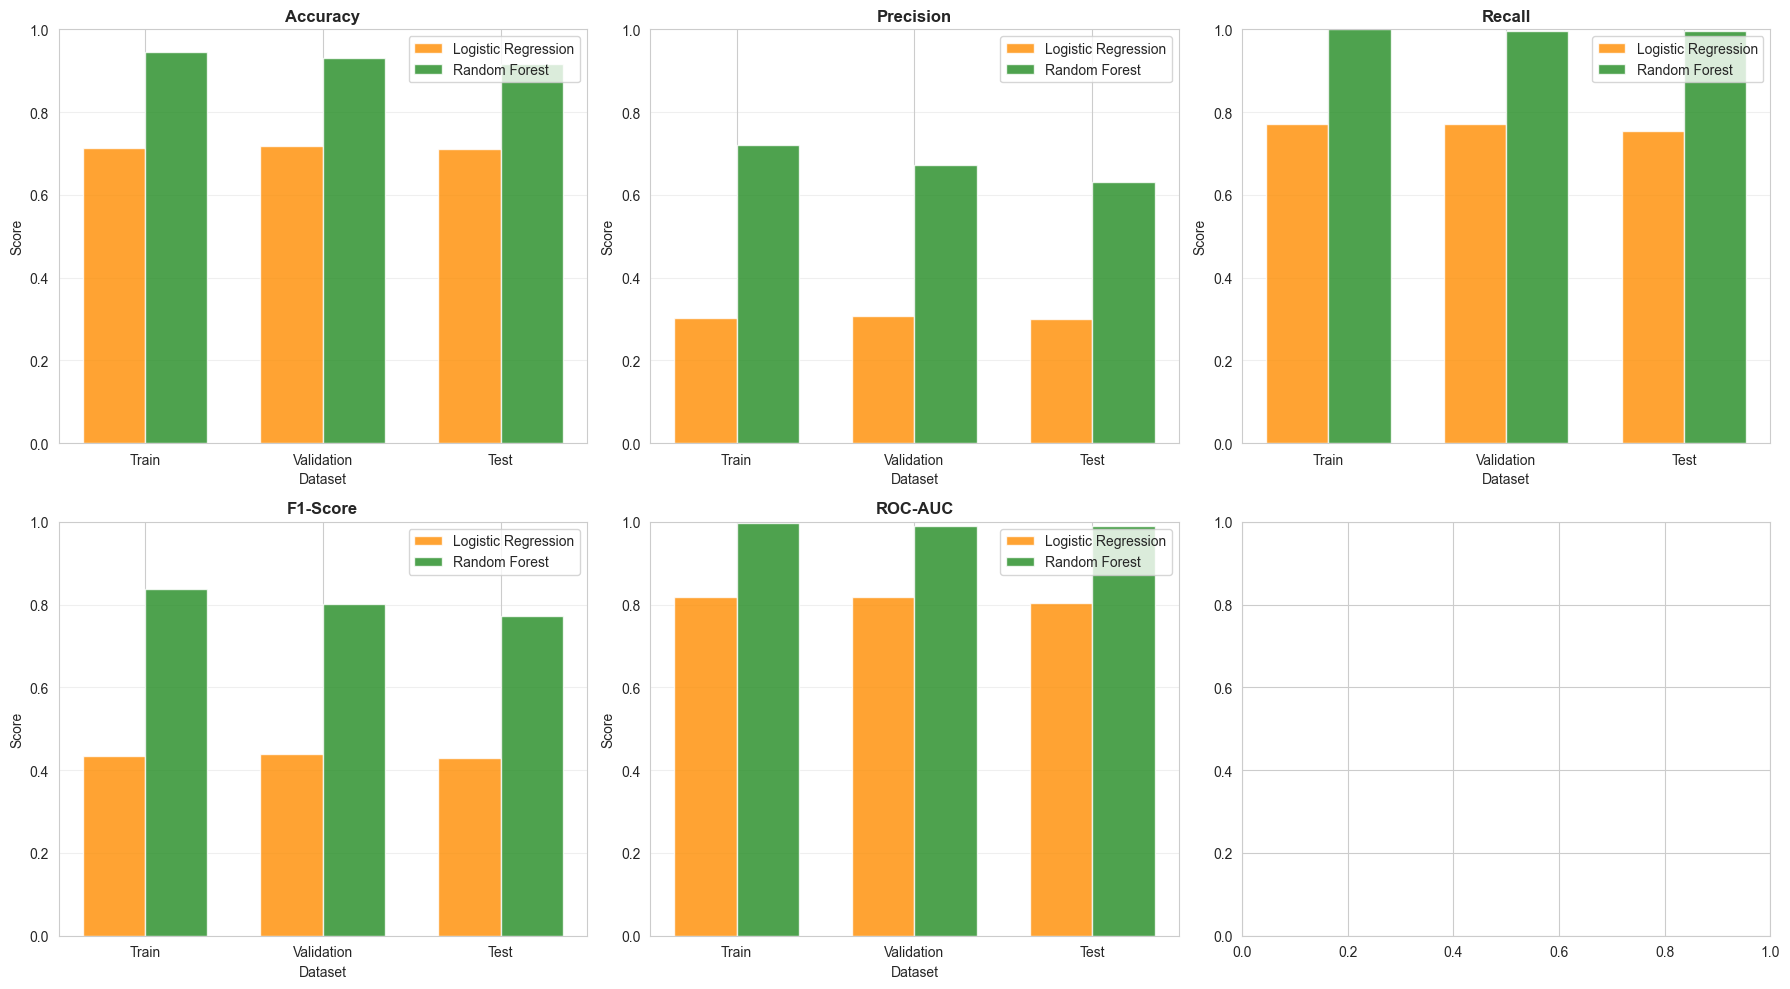


Model comparison complete!


In [10]:
# ============================================================
# MODEL COMPARISON
# ============================================================

print("\n" + "=" * 60)
print("MODEL COMPARISON")
print("=" * 60)

# Create comprehensive comparison dataframe
comparison_data = {
    'Model': ['Logistic Regression', 'Logistic Regression', 'Logistic Regression',
              'Random Forest', 'Random Forest', 'Random Forest'],
    'Set': ['Train', 'Validation', 'Test', 'Train', 'Validation', 'Test'],
    'Accuracy': [lr_train_metrics['accuracy'], lr_val_metrics['accuracy'], lr_test_metrics['accuracy'],
                 rf_train_metrics['accuracy'], rf_val_metrics['accuracy'], rf_test_metrics['accuracy']],
    'Precision': [lr_train_metrics['precision'], lr_val_metrics['precision'], lr_test_metrics['precision'],
                  rf_train_metrics['precision'], rf_val_metrics['precision'], rf_test_metrics['precision']],
    'Recall': [lr_train_metrics['recall'], lr_val_metrics['recall'], lr_test_metrics['recall'],
               rf_train_metrics['recall'], rf_val_metrics['recall'], rf_test_metrics['recall']],
    'F1-Score': [lr_train_metrics['f1'], lr_val_metrics['f1'], lr_test_metrics['f1'],
                 rf_train_metrics['f1'], rf_val_metrics['f1'], rf_test_metrics['f1']],
    'ROC-AUC': [lr_train_metrics['roc_auc'], lr_val_metrics['roc_auc'], lr_test_metrics['roc_auc'],
                rf_train_metrics['roc_auc'], rf_val_metrics['roc_auc'], rf_test_metrics['roc_auc']]
}

comparison = pd.DataFrame(comparison_data)
print("\n", comparison.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

# Mapping from display metric names to dictionary keys
metric_key_map = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1-score': 'f1',  # Special case: 'F1-Score' -> 'f1' not 'f1_score'
    'roc-auc': 'roc_auc'
}

for idx, metric in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]
    x = np.arange(3)  # Train, Validation, Test
    width = 0.35
    
    # Get the correct dictionary key
    metric_key = metric_key_map[metric.lower()]
    
    lr_values = [
        lr_train_metrics[metric_key],
        lr_val_metrics[metric_key], 
        lr_test_metrics[metric_key]
    ]
    rf_values = [
        rf_train_metrics[metric_key],
        rf_val_metrics[metric_key], 
        rf_test_metrics[metric_key]
    ]
    
    ax.bar(x - width/2, lr_values, width, label='Logistic Regression', 
           color='darkorange', alpha=0.8)
    ax.bar(x + width/2, rf_values, width, label='Random Forest', 
           color='forestgreen', alpha=0.8)
    
    ax.set_xlabel('Dataset', fontsize=10)
    ax.set_ylabel('Score', fontsize=10)
    ax.set_title(metric, fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(['Train', 'Validation', 'Test'])
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1.0])

plt.tight_layout()
plt.show()

print("\nModel comparison complete!")

### 4.1 Best Model Selection

The best model is selected based on validation ROC-AUC score, as this metric is less sensitive to class imbalance and provides a good overall measure of model performance.

In [11]:
# Determine best model based on validation ROC-AUC
print("\nBEST MODEL (based on Validation ROC-AUC):")
if rf_val_metrics['roc_auc'] > lr_val_metrics['roc_auc']:
    print(f"   Random Forest (Val ROC-AUC: {rf_val_metrics['roc_auc']:.4f})")
    best_model = 'Random Forest'
    # Note: best_model_obj, best_val_pred, best_test_pred, best_val_proba, best_test_proba
    # are kept for reference but are not used in this notebook.
    # Fairness analysis is performed in notebook 03_fairness_analysis.ipynb
    best_model_obj = rf_model
    best_val_pred = y_val_pred_rf
    best_test_pred = y_test_pred_rf
    best_val_proba = y_val_proba_rf
    best_test_proba = y_test_proba_rf
else:
    print(f"   Logistic Regression (Val ROC-AUC: {lr_val_metrics['roc_auc']:.4f})")
    best_model = 'Logistic Regression'
    # Note: best_model_obj, best_val_pred, best_test_pred, best_val_proba, best_test_proba
    # are kept for reference but are not used in this notebook.
    # Fairness analysis is performed in notebook 03_fairness_analysis.ipynb
    best_model_obj = logistic_model
    best_val_pred = y_val_pred_lr
    best_test_pred = y_test_pred_lr
    best_val_proba = y_val_proba_lr
    best_test_proba = y_test_proba_lr

print(f"\n   Test Set Performance:")
if best_model == 'Random Forest':
    print(f"   ROC-AUC: {rf_test_metrics['roc_auc']:.4f}")
    print(f"   F1-Score: {rf_test_metrics['f1']:.4f}")
else:
    print(f"   ROC-AUC: {lr_test_metrics['roc_auc']:.4f}")
    print(f"   F1-Score: {lr_test_metrics['f1']:.4f}")

print("\nSummary Statistics:")
print(f"   Overfitting check (Train vs Val ROC-AUC difference):")
print(f"   LR: {abs(lr_train_metrics['roc_auc'] - lr_val_metrics['roc_auc']):.4f}")
print(f"   RF: {abs(rf_train_metrics['roc_auc'] - rf_val_metrics['roc_auc']):.4f}")

lr_overfit = abs(lr_train_metrics['roc_auc'] - lr_val_metrics['roc_auc'])
rf_overfit = abs(rf_train_metrics['roc_auc'] - rf_val_metrics['roc_auc'])
if lr_overfit > 0.1:
    print(f"   WARNING: Logistic Regression may be overfitting (gap: {lr_overfit:.4f})")
if rf_overfit > 0.1:
    print(f"   WARNING: Random Forest may be overfitting (gap: {rf_overfit:.4f})")


BEST MODEL (based on Validation ROC-AUC):
   Random Forest (Val ROC-AUC: 0.9907)

   Test Set Performance:
   ROC-AUC: 0.9907
   F1-Score: 0.7723

Summary Statistics:
   Overfitting check (Train vs Val ROC-AUC difference):
   LR: 0.0009
   RF: 0.0074


## 5. Save Models and Predictions

Save all models, predictions, and metrics for downstream fairness analysis.


In [12]:
# ============================================================
# SAVE MODELS AND PREDICTIONS
# ============================================================

print("\n" + "=" * 60)
print("SAVING MODELS AND PREDICTIONS")
print("=" * 60)

# Create results directory
results_dir = Path('../results')
results_dir.mkdir(exist_ok=True)

# Save models
print("Saving models...")
with open(results_dir / 'logistic_regression_model.pkl', 'wb') as f:
    pickle.dump(logistic_model, f)
    
with open(results_dir / 'random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

print("Models saved")

# Save predictions and probabilities
assert len(y_test_pred_lr) == len(y_test), "LR Prediction length mismatch"
assert len(y_test_proba_lr) == len(y_test), "LR Probability length mismatch"
assert len(y_test_pred_rf) == len(y_test), "RF Prediction length mismatch"
assert len(y_test_proba_rf) == len(y_test), "RF Probability length mismatch"

print("Saving predictions...")

# Logistic Regression predictions
with open(results_dir / 'lr_train_predictions.pkl', 'wb') as f:
    pickle.dump(y_train_pred_lr, f)
with open(results_dir / 'lr_val_predictions.pkl', 'wb') as f:
    pickle.dump(y_val_pred_lr, f)
with open(results_dir / 'lr_test_predictions.pkl', 'wb') as f:
    pickle.dump(y_test_pred_lr, f)

with open(results_dir / 'lr_train_proba.pkl', 'wb') as f:
    pickle.dump(y_train_proba_lr, f)
with open(results_dir / 'lr_val_proba.pkl', 'wb') as f:
    pickle.dump(y_val_proba_lr, f)
with open(results_dir / 'lr_test_proba.pkl', 'wb') as f:
    pickle.dump(y_test_proba_lr, f)

# Random Forest predictions
with open(results_dir / 'rf_train_predictions.pkl', 'wb') as f:
    pickle.dump(y_train_pred_rf, f)
with open(results_dir / 'rf_val_predictions.pkl', 'wb') as f:
    pickle.dump(y_val_pred_rf, f)
with open(results_dir / 'rf_test_predictions.pkl', 'wb') as f:
    pickle.dump(y_test_pred_rf, f)

with open(results_dir / 'rf_train_proba.pkl', 'wb') as f:
    pickle.dump(y_train_proba_rf, f)
with open(results_dir / 'rf_val_proba.pkl', 'wb') as f:
    pickle.dump(y_val_proba_rf, f)
with open(results_dir / 'rf_test_proba.pkl', 'wb') as f:
    pickle.dump(y_test_proba_rf, f)

print("Predictions saved")

# Save metrics
print("Saving metrics...")
baseline_metrics = {
    'logistic_regression': {
        'train': {k: float(v) for k, v in lr_train_metrics.items() if k != 'set'},
        'validation': {k: float(v) for k, v in lr_val_metrics.items() if k != 'set'},
        'test': {k: float(v) for k, v in lr_test_metrics.items() if k != 'set'}
    },
    'random_forest': {
        'train': {k: float(v) for k, v in rf_train_metrics.items() if k != 'set'},
        'validation': {k: float(v) for k, v in rf_val_metrics.items() if k != 'set'},
        'test': {k: float(v) for k, v in rf_test_metrics.items() if k != 'set'}
    },
    'best_model': best_model,
    'feature_importance': feature_importance.to_dict('records')[:20]  # Top 20 features
}

with open(results_dir / 'baseline_metrics.json', 'w') as f:
    json.dump(baseline_metrics, f, indent=2)

print("Metrics saved")

print(f"\nAll files saved to: {results_dir.absolute()}")
print("\nSaved files:")
print("  Models:")
print("    - logistic_regression_model.pkl")
print("    - random_forest_model.pkl")
print("  Predictions (Logistic Regression):")
print("    - lr_train_predictions.pkl, lr_val_predictions.pkl, lr_test_predictions.pkl")
print("    - lr_train_proba.pkl, lr_val_proba.pkl, lr_test_proba.pkl")
print("  Predictions (Random Forest):")
print("    - rf_train_predictions.pkl, rf_val_predictions.pkl, rf_test_predictions.pkl")
print("    - rf_train_proba.pkl, rf_val_proba.pkl, rf_test_proba.pkl")
print("  Metrics:")
print("    - baseline_metrics.json")

print("\n" + "=" * 60)
print("NOTEBOOK COMPLETE!")
print("=" * 60)
print("Next steps:")
print("  Proceed to notebook 03_fairness_analysis.ipynb")
print("  Load models and predictions from ../results/ directory")



SAVING MODELS AND PREDICTIONS
Saving models...
Models saved
Saving predictions...
Predictions saved
Saving metrics...
Metrics saved

All files saved to: c:\Users\Anthony Stills Jr\Documents\CS Projects\insurance-fairness\notebooks\..\results

Saved files:
  Models:
    - logistic_regression_model.pkl
    - random_forest_model.pkl
  Predictions (Logistic Regression):
    - lr_train_predictions.pkl, lr_val_predictions.pkl, lr_test_predictions.pkl
    - lr_train_proba.pkl, lr_val_proba.pkl, lr_test_proba.pkl
  Predictions (Random Forest):
    - rf_train_predictions.pkl, rf_val_predictions.pkl, rf_test_predictions.pkl
    - rf_train_proba.pkl, rf_val_proba.pkl, rf_test_proba.pkl
  Metrics:
    - baseline_metrics.json

NOTEBOOK COMPLETE!
Next steps:
  Proceed to notebook 03_fairness_analysis.ipynb
  Load models and predictions from ../results/ directory
